# Equality Constrained Convex Quadratic Program Solvers

## Imports

In [ ]:
#%conda install -c conda-forge cvxopt
#%conda install -c conda-forge casadi
#%conda install -c conda-forge matplotlib
#%conda install pandas



Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/asherkite/Desktop/School/Courses/OR/github/Constrained-Optimization/.conda

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.4.2           |  py311hb9f6ed7_0         127 KB
    numexpr-2.10.1             |  py311h5d9532f_0         185 KB
    pandas-2.2.3               |  py311hcf29cfe_0        14.9 MB
    python-tzdata-2025.2       |     pyhd3eb1b0_0         141 KB
    pytz-2024.1                |  py311hca03da5_0         222 KB
    ------------------------------------------------------------
                                           Total:        15.6 MB

The following NEW packages will be INSTALLED:

  bottleneck         pkgs/main/osx-arm64::bottleneck-1.4.2-py311hb9f6ed7_0 
  numexpr            pkgs/main/osx-arm64:

In [4]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import splu, spsolve
from scipy.sparse import csc_matrix, csr_matrix, dia_matrix
import casadi as ca
from casadi import *
import matplotlib.pyplot as plt
import cvxopt as cvx
from cvxopt import cholmod
import time

# Problem 1.3

The Goal here is to find x and y which solve the KKT matrix algebra problem:


$ \begin{bmatrix} H & -A \\ -A^T & 0 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -g \\ -b \end{bmatrix} $

This formulation is slightly different from what can be found on page 451 of the texbook. There are the following differences:    
* We define $A$ as the transpose of the textbook's definition: $A_{report} = A^T_{texbook}$
* We have some different variable names: $H_{report} = G_{textbook}$, and $g_{report} = c_{textbook}$
* We have a negative sign in from of the bottom left $A$ matrix, and in front of $b$.
    
    - This is permissible since $-Ax = -b$ implies $Ax = b$ and vice versa (that is to say, we are solving for the same $x$ and $y$).

    - This is required since we need the KKT matrix to be symmetric for factorization.                   

## Dense LU Factorization

In [5]:
def EqualityQPSolverLUdense(H,g,A,b):

    _, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])
    L, U = sp.linalg.lu(KKT, permute_l = True)
    rhs = -np.concatenate([g, b], axis=0) 
    midd = np.linalg.solve(L, rhs)
    sol = np.linalg.solve(U, midd)

    xout = sol[:len(g)]
    yout = sol[len(g):]
    
    return xout, yout

## Sparse LU Factorization

In [6]:
def EqualityQPSolverLUsparse(H,g,A,b):

    _, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])
    L, U = sp.linalg.lu(KKT, permute_l = True)
    L = csc_matrix(L) 
    U = csc_matrix(U)
    rhs = csc_matrix(-np.concatenate([g, b], axis=0) )
    midd = sp.sparse.linalg.spsolve(L, rhs)
    sol = np.array(sp.sparse.linalg.spsolve(U, midd))

    xout = sol[:len(g)]
    yout = sol[len(g):]
    
    return np.array([xout]).T, np.array([yout]).T

In [7]:
def EqualityQPSolverLUsparse_smart(H,g,A,b):

    _, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT = sp.sparse.csc_matrix(np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])) #define the KKT matrix as a csc matrix
    LUsparse= splu(KKT) # the sparse lu function from scipy uses csc matrices. This produces an object with a .solve function
    rhs = -np.concatenate([g, b], axis=0)
    sol = LUsparse.solve(rhs) #using the .solve functionality to get the solution

    xout = sol[:len(g)]
    yout = sol[len(g):]
    
    return xout, yout

## Dense LDL.T Factorization

In [8]:
def EqualityQPSolverLDLdense(H,g,A,b):

    _, Am = A.shape 
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]]) #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    L, D, perm = sp.linalg.ldl(KKT) #scipy's linalg.ldl performs a dense LDL.T decomposition
    rhs = -np.concatenate([g, b], axis=0) 
    midd1 = np.linalg.solve(L, rhs) #here we solve the system using the LDL.T factorization
    midd2 = np.linalg.solve(D, midd1)
    sol = np.linalg.solve(L.T, midd2) 
    xout = sol[:len(g)]
    yout = sol[len(g):]
    
    return xout, yout

## Sparse LDL.T Factorization

In [9]:
def EqualityQPSolverLDLsparse(H,g,A,b):

    _, Am = A.shape 
    KKT = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]]) #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    L, D, perm = sp.linalg.ldl(KKT) #scipy's linalg.ldl performs a dense LDL.T decomposition
    L = csc_matrix(L)
    D = csc_matrix(D)

    rhs = csc_matrix(-np.concatenate([g, b], axis=0)) 
    midd1 = sp.sparse.linalg.spsolve(L, rhs) #here we solve the system using the LDL.T factorization
    midd2 = sp.sparse.linalg.spsolve(D, midd1)
    sol = sp.sparse.linalg.spsolve(L.T, midd2) 
    xout = sol[:len(g)]
    yout = sol[len(g):]
    
    return np.array([xout]).T, np.array([yout]).T

In [10]:
def EqualityQPSolveLDLsparse2(H,g,A,b): #borken
    An, Am = A.shape #note that An = Hn = Hm, so we use Am for the dimensions of the 0 matrix
    KKT_np = np.block([[H, -A],[-A.T,np.zeros([Am,Am])]])
    print(KKT_np)
    print(sp.linalg.det(KKT_np))
    KKT = sp.sparse.csc_matrix(KKT_np) #we make the KKT sparse in preparation for converting to cvxopt
    # For the sparse LDL solver we utilize cvxopt. However, first we must convert our scipy sparse KKT matrix to a cvxopt sparse matrix
    # since cvxopt uses Fortran (column) indexing, this requires some maneuvering
    data = KKT.data
    indices = KKT.indices 
    indptr = KKT.indptr
    I = []
    J = []
    V = []
    for col in range(KKT.shape[1]):
        for idx in range(indptr[col], indptr[col+1]):
            I.append(int(indices[idx]))
            J.append(int(col))
            V.append(float(data[idx]))
    KKT_cvx = cvx.spmatrix(V, I, J, KKT.shape)
    print(KKT_cvx)
    vec = -np.concatenate([g, b], axis=0)
    print(vec)
    vec_cvx = cvx.matrix(vec)
    print(vec_cvx)
    # Symbolic analysis
    F = cholmod.symbolic(KKT_cvx)

    # Numeric factorization
    cholmod.numeric(KKT_cvx, F)

    # Solve A x = b
    out_vec = np.array(cholmod.solve(F, vec_cvx,sys=1))

    xout = out_vec[:len(g)]
    yout = out_vec[len(g):]
    
    return xout, yout

## Range Space Method
More info in lecture 5 QuadraticOptimization page 20/23.
Useful when H is easy to invert or known explicitly, and when there are few equality constraints.

In [11]:
def EqualityQPSolverRange(H,g,A,b):
    Hinv = sp.linalg.inv(H) #most costly line
    A_T = A.T
    v = np.linalg.solve(H,g)
    y = np.linalg.solve((A_T@Hinv@A),b+(A_T@v))
    x = np.linalg.solve(H,(A@y-g))
    return x, y

## Null Space Method
Read more in lecture 5 QuadraticOptiization page 22/23. Useful when an-am is small.

In [12]:
def EqualityQPSolverNull(H,g,A,b):
    #This one is built from: Lecture 5 QuadraticOptimization page 22/23: https://learn.inside.dtu.dk/d2l/le/lessons/242131/topics/969401
    _, Am = A.shape 
    A_T = A.T
    Y,R = sp.linalg.qr(A,mode='economic') #This works but must be justified: goal: A^T@Y is nonsingular.
    Z = sp.linalg.null_space(A_T) #Note that we want A^T@Z=0, so Z is the null space of A^T
    Y_T = Y.T
    Z_T = Z.T
    x_Y = np.linalg.solve((A_T@Y),b)
    x_Z = np.linalg.solve((Z_T@H@Z),-Z_T@((H@Y@x_Y)+g))
    x = (Y@x_Y)+(Z@x_Z)
    y = np.linalg.solve((A_T@Y).T,Y_T@((H@x)+g))
    return x, y

In [13]:
def EqualityQPSolver(H,g,A,b,solver="LDLdense"):
    if solver == "LUdense":
        return EqualityQPSolverLUdense(H,g,A,b)
    if solver == "LUsparse":
        return EqualityQPSolverLUsparse(H,g,A,b)
    if solver == "LDLdense":
        return EqualityQPSolverLDLdense(H,g,A,b)
    if solver == "LDLsparse":
        return EqualityQPSolverLDLsparse(H,g,A,b)
    if solver == "Range":
        return EqualityQPSolverRange(H,g,A,b)
    if solver == "Null":
        return EqualityQPSolverNull(H,g,A,b)
    #specialty solvers:
    if solver == "LUsparse_smart":
        return EqualityQPSolverLUsparse_smart(H,g,A,b)
    else:
        raise ValueError("###---Unknown Solver---###")

In [14]:
solvers = ["LUdense","LUsparse","LDLdense","LDLsparse","Range","Null","LUsparse_smart"]
for s in solvers:
    print("-----",s,"-----")
    x, y = EqualityQPSolver(H,g,A,b,s)
    print("    x.T:",x.T)
    print("x.shape:",x.shape)

----- LUdense -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- LUsparse -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- LDLdense -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- LDLsparse -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- Range -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- Null -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)
----- LUsparse_smart -----
    x.T: [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]]
x.shape: (5, 1)


# Problem 1.4
Julian made the random_gp function! Asher added modifications!

In [15]:
def random_qp(n, alpha, beta, density):
        m = int(np.round(beta * n))
        A = sp.sparse.random(n, m, density=density, format='csr', data_rvs=np.random.randn).toarray()
        x0 = np.random.randn(n,1)
        y0 = np.random.randn(m,1)
        bl = A.T @ x0
        bu = bl
        M = sp.sparse.random(n, n, density=density, format='csr', data_rvs=np.random.randn)
        H = (M @ M.T).toarray() + (alpha * np.eye(n))
        g = -(H@x0 - A@y0)
        l = np.full(n, -np.inf)
        u = np.full(n,  np.inf)
        return H, g, A, bl, bu, l, u

In [16]:
def random_qp_strict(n, alpha, beta, density):
        m = int(np.round(beta * n))
        A = sp.sparse.random(n, m, density=density, format='csr', data_rvs=np.random.randn).toarray()

        it_count=0
        while np.linalg.matrix_rank(A.T) != A.T.shape[0]:
            A = sp.sparse.random(n, m, density=density, format='csr', data_rvs=np.random.randn).toarray()
            it_count+=1
            if it_count>10000: raise ValueError("###---Too Many Iterations---###")

        x0 = np.random.randn(n,1)
        y0 = np.random.randn(m,1)
        bl = A.T @ x0
        bu = bl
        M = sp.sparse.random(n, n, density=density, format='csr', data_rvs=np.random.randn)
        H = (M @ M.T).toarray() + (alpha * np.eye(n))
        g = -(H@x0 - A@y0)
        l = np.full(n, -np.inf)
        u = np.full(n,  np.inf)
        return H, g, A, bl, bu, l, u

# Problem 1.5

## Casadi Functions
We need a baseline to compare to, so we make functions to convert to and from Casadi

In [17]:
#We need a converter to get to Casadi formatting
def QP_Convert_To_Casadi(Hin, gin, Ain, bin): #This function accepts H, g, A, and b, and outputs Casadi's inputs

    # Convert all arrays to CASADI types first
    Hout = ca.SX(Hin)
    gout = ca.SX(gin)

    # Build constraint matrix
    Aout = ca.SX(Ain.T)


    # Build bounds
    lbg = ca.DM(bin)
    ubg = ca.DM(bin)
    
    Hn, _ = Hin.shape
    lbx = ca.DM(np.full((1, Hn), -np.inf))
    ubx = ca.DM(np.full((1, Hn),  np.inf))
        
    return Hout, gout, Aout, lbx, ubx, lbg, ubg

In [19]:
#This function accepts H, g, A, and b, and returns the Casadi solution
def Casadi_EC_QP(Hin,gin,Ain,bin): #This function accepts the same initial data that our solver accepts, and then returns the Casadi solution.
    nh, _ = Hin.shape
        
    H, g, A, lbx_, ubx_, lbg_, ubg_ = QP_Convert_To_Casadi(Hin,gin,Ain,bin)

    #print("H shape:", H.shape)
    #print("g shape:",g.shape)
    #print("A shape:", A.shape)
    #print("lbg shape:", lbg_.shape)
    #print("ubg shape:", ubg_.shape)

    # Define symbolic decision variable
    x = ca.SX.sym('x', nh) 

    # Objective: minimize 0.5 * x^T H x + g^T x
    objective = 0.5 * ca.dot(x, ca.mtimes(H, x)) + ca.dot(g, x)

    # Constraint: 
    constraint = ca.mtimes(A, x)

    # Define the QP in symbolic form
    qp = {
        'x': x,       # decision variables
        'f': objective,
        'g': constraint
    }

    # Create solver
    solver = ca.qpsol('S', 'qpoases', qp)

    # Call solver with bounds (symbolic part already defined)
    sol = solver(
        lbx=lbx_, 
        ubx=ubx_,  
        lbg=lbg_,   # 
        ubg=ubg_  #   
    )

    return sol['x']

In [20]:
def run_Casadi(H,g,A,bl,bu,l,u):
    nh, _ = H.shape

    H = ca.SX(H)
    g = ca.SX(g)
    A = ca.SX(A.T)
    lbg = ca.DM(bl)
    ubg = ca.DM(bu)
    lbx = ca.DM(l)
    ubx = ca.DM(u)

    x = ca.SX.sym('x', nh) 

    # Objective: minimize 0.5 * x^T H x + g^T x
    objective = 0.5 * ca.dot(x, ca.mtimes(H, x)) + ca.dot(g, x)

    # Constraint: 
    constraint = ca.mtimes(A, x)

    # Define the QP in symbolic form
    qp = {
        'x': x,       # decision variables
        'f': objective,
        'g': constraint
    }

    opts = {
    "printLevel": "none",   # Options: none, low, medium, high, debug
    }


    # Create solver
    solver = ca.qpsol('S', 'qpoases', qp, opts)

    # Call solver with bounds (symbolic part already defined)
    sol = solver(
        lbx=lbx, 
        ubx=ubx,  
        lbg=lbg,   # 
        ubg=ubg  #   
    )

    return sol['x']


## Accuracy Test


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Onl

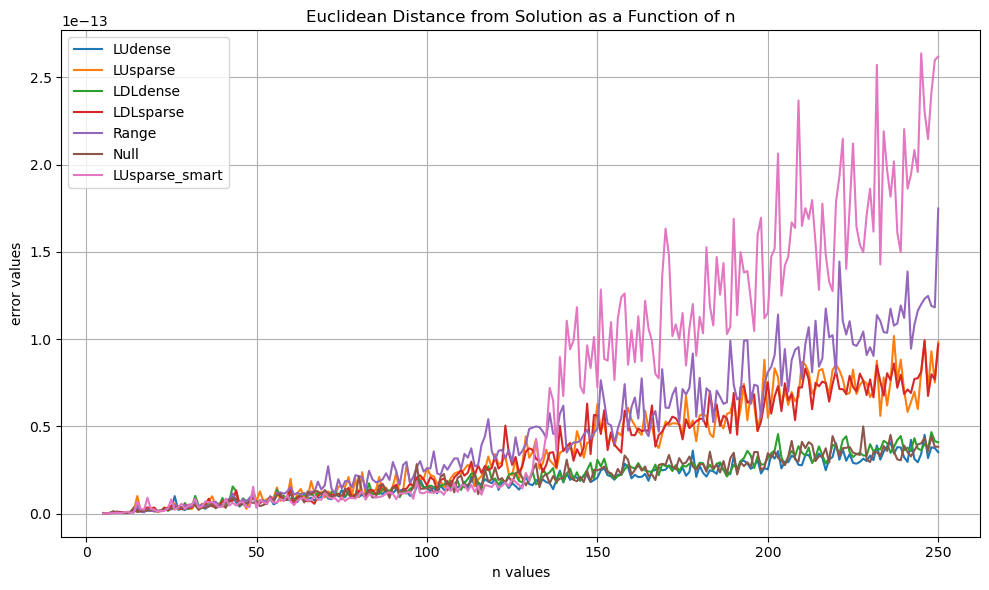

In [ ]:

def return_accuracy(solvers= ["LUdense","LUsparse","LDLdense","LDLsparse","Range","Null","LUsparse_smart"], n=100,alpha=1,beta=0.5,density=0.15):
    H, g, A, bl, bu, l, u = random_qp_strict(n,alpha,beta,density)
    Casadi_x = np.array(run_Casadi(H,g,A,bl,bu,l,u))

    error_row = np.zeros(len(solvers))
    for i in range(len(solvers)):
        xout, _ = EqualityQPSolver(H,g,A,bl,solvers[i])
        error_row[i]=np.linalg.norm(Casadi_x-xout,ord=2)
        
    return(error_row)

n_list = np.arange(5,201)
solvers= ["LUdense","LUsparse","LDLdense","LDLsparse","Range","Null","LUsparse_smart"]

x_err_mat = np.zeros((len(n_list),len(solvers)))

for i in range(len(n_list)):
    x_err_mat[i,:] = return_accuracy(solvers,n_list[i])


#plotting it all:
plt.figure(figsize=(10, 6))
for i in range(x_err_mat.shape[1]):
    plt.plot(n_list, x_err_mat[:, i], label=solvers[i])

plt.xlabel('n values')
plt.ylabel('error values')
plt.title('Euclidean Distance from Solution as a Function of n')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


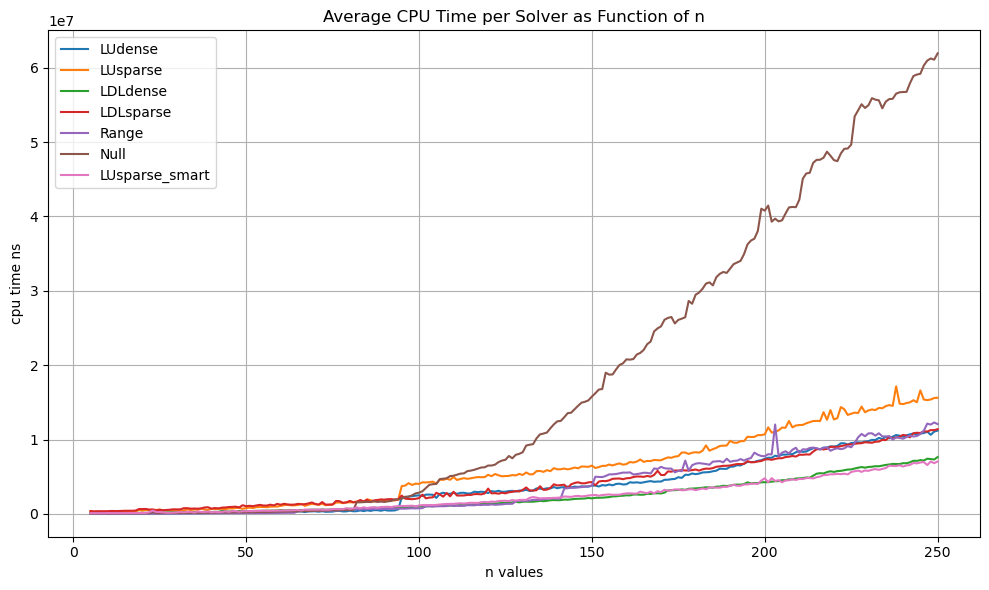

In [109]:
def return_cputime(solvers= ["LUdense","LUsparse","LDLdense","LDLsparse","Range","Null","LUsparse_smart"], n=100,alpha=1,beta=0.5,density=0.15):
    H, g, A, bl, bu, l, u = random_qp_strict(n,alpha,beta,density)
    
    time_row = np.zeros(len(solvers))
    for i in range(len(solvers)):
        average_time = 0
        num = 25
        for j in range(num):
            t = time.process_time_ns()
            xout, _ = EqualityQPSolver(H,g,A,bl,solvers[i])
            average_time+=time.process_time_ns()-t
        time_row[i]=average_time / num
        
    return(time_row)



n_list = np.arange(5,251)
solvers= ["LUdense","LUsparse","LDLdense","LDLsparse","Range","Null","LUsparse_smart"]

cputime_mat = np.zeros((len(n_list),len(solvers)))

for i in range(len(n_list)):
    cputime_mat[i,:] = return_cputime(solvers,n_list[i])


#plotting it all:
plt.figure(figsize=(10, 6))
for i in range(cputime_mat.shape[1]):
    plt.plot(n_list, cputime_mat[:, i], label=solvers[i])

plt.xlabel('n values')
plt.ylabel('cpu time ns')
plt.title('Average CPU Time per Solver as Function of n')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Problem 1.6
In this section we solve a provided test question using one of our QP solvers, and compare the solution which Casadi finds.

## Defining the Test Problem

In [ ]:
#Defining the test problem for 1.6
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])


g = np.array([
    [-16.1000],
    [-8.5000],
    [-15.7000],
    [-10.0200],
    [-18.6800]
])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])


b = np.array([
    [15],
    [1]
])



## Solving the Test Problem

In [ ]:
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])


g = np.array([
    [-16.1000],
    [-8.5000],
    [-15.7000],
    [-10.0200],
    [-18.6800]
])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])


b = np.array([
    [15],
    [1]
])


#First we solve the test problem with one of our solvers:
x, y = EqualityQPSolverNull(H,g,A,b)
print("x:\n",x.T,"\ny:\n",y.T)

#Next we do so with Casadi

print(np.array(Casadi_EC_QP(H,g,A,b)).flatten())

import numpy as np
import pandas as pd
Our_x = x.flatten()
Cas_x = np.array(Casadi_EC_QP(H, g, A, b)).flatten()
AbsDif = np.abs(Our_x-Cas_x)
EucDist = np.linalg.norm(Our_x - Cas_x, ord=2)
EucDistVec = np.full(len(Our_x), np.nan)
EucDistVec[0]= EucDist

# Create a dataframe 
df = pd.DataFrame({
    'Our Solution': Our_x,           # Our solution
    'CasADi Solution': Cas_x,        # CasADi's solution
    "Absolute_Difference": AbsDif,   # The absolute difference between each component of Our_x and Cas_x
    'Euclidean_Distance': EucDistVec # This is the Euclidean distance between CasADi's solution and ours
})
# Save to CSV
df.to_csv('1.6_Solution_Comparison.csv')

x:
 [[0.15020779 0.1400325  0.35434944 0.09364569 0.26176457]] 
y:
 [[-0.94962455  0.80823969]]

qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See t

## Comparison

Our dense LDL solver finds:

x = [0.15020779, 0.1400325, 0.35434944, 0.09364569, 0.26176457]

Casadi finds:

x = [0.150208, 0.140033, 0.354349, 0.0936457, 0.261765]

These solutions are satisfactorily similar.

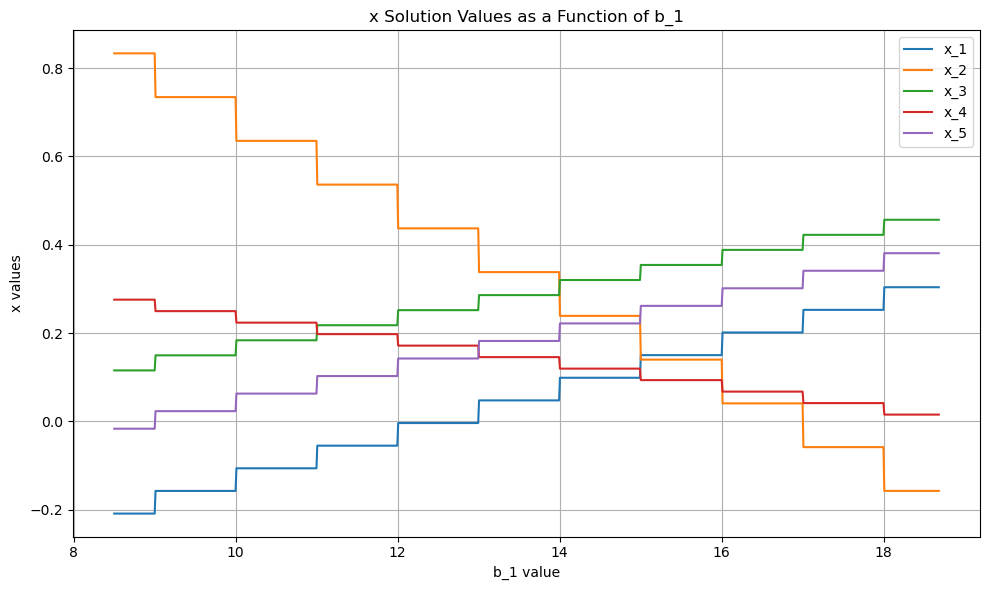

In [ ]:
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])


g = np.array([
    [-16.1000],
    [-8.5000],
    [-15.7000],
    [-10.0200],
    [-18.6800]
])

A = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])


b = np.array([
    [15],
    [1]
])

bn = 1000
b1_space = np.linspace(8.50,18.68,bn)
xsol_matrix = np.zeros((bn,5))

for b_id in range(len(b1_space)):
    b[0,0]=b1_space[b_id]
    xsol, _ = EqualityQPSolverLUdense(H,g,A,b)
    xsol_matrix[b_id,:] = xsol.flatten()



plt.figure(figsize=(10, 6))
for i in range(xsol_matrix.shape[1]):
    plt.plot(b1_space, xsol_matrix[:, i], label=f'x_{i + 1}')

plt.xlabel('b_1 value')
plt.ylabel('x values')
plt.title('x Solution Values as a Function of b_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
